# Day 7: Estatística avançada - Data Expert DNC

### Carregamento das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import patsy as pt
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV
from sklearn import metrics

In [2]:
def desc_null(df, percentiles=False):
  """Função para descrição de dados, incluindo colunas de contagem de nulos e porcentagem de nulos em cada variável

  Args:
      df (pd.DataFrame): base de dados para descrição
      percentiles (bool, optional): exibição dos percentis [0.05, 0.25, 0.5, 0.75, 0.9, 0.99]. Defaults to False.

  Returns:
      des(pd.DataFrame): descrição dos dados com a quantidade e porcentagem de nulos por feature
  """ 
  import pandas as pd
  
  if percentiles is True:
    des = df.describe(datetime_is_numeric=True,
                      percentiles=[0.05, 0.25, 0.5, 0.75, 0.9, 0.99]).T
    des["nullCount"] = df.shape[0] - des["count"]
    des["null%"] = (des["nullCount"] / df.shape[0]) * 100

  else:
    des = df.describe(include='all', 
                      datetime_is_numeric=True).T
    des['nullCount'] = df.shape[0] - des['count']
    des['null%'] = (des['nullCount'] / df.shape[0]) * 100
    
  return des

In [3]:
def histplot(data=None, title=None, xlabel=None, ylabel=None, x=None, y=None, ax=False, nrows=1, ncols=1, figsize=(10, 5), bins=10):
  """Gráfico de frequência pra visualização de dados numéricos e categóricos

  Args:
      data (pd.DataFrame): base de dados
      title (str, optional): título do gráfico, opcional. Defaults to None.
      xlabel (str, optional): título do eixo x, opcional. Defaults to None.
      ylabel (str, optional): título do eixo y, opcional. Defaults to None.
      x (str, optional): feature da base de dados para o eixo x. Defaults to None.
      y (str, optional): feature da base de dados para o eixo y. Defaults to None.
      ax (bool, optional): determina se a impressão conterá múltiplos gráficos. Defaults to False.
      nrows (int, optional): quantidade de linhas. Defaults to 1.
      ncols (int, optional): quantidade de colunas. Defaults to 1.
      figsize (tuple, optional): tamanho da impressão. Defaults to (10, 5).
      bins (int, optional): quantidade de bins. Defaults to 10.

  Returns:
      sns.histplot: impressão do gráfico
  """   
  import matplotlib.pyplot as plt
  import seaborn as sns
  
  if ax is True:
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    c = 0
    if len(x) < (nrows * ncols):      
      for i in range(nrows):
        for j in range(ncols):
          if i == nrows-1 and j == ncols-1:
            fig.delaxes(axes[nrows-1,ncols-1])
          else:
            sns.histplot(data=data, x=x[c], y=y, bins=bins, ax=axes[i,j]).set_ylabel(ylabel)
            c += 1
            
    elif nrows > 1 and ncols > 1:
      for i in range(nrows):
        for j in range(ncols):
          sns.histplot(data=data, x=x[c], y=y, bins=bins, ax=axes[i,j]).set_ylabel(ylabel)
          c += 1
    elif nrows == 0:
      for j in range(ncols):
        sns.histplot(data=data, x=x[c], y=y, bins=bins, ax=axes[j]).set_ylabel(ylabel)
        c += 1
    elif ncols == 0:
      for i in range(nrows):
        sns.histplot(data=data, x=x[c], y=y, bins=bins, ax=axes[i]).set_ylabel(ylabel)
        c += 1
    if title is not None:
      fig.suptitle(title)
  
  else:
    plt.figure(figsize=figsize)
    sns.histplot(data=data, x=x, y=y, bins=bins)
    
    if title is not None:
      plt.title(title)
    if xlabel is not None:
      plt.xlabel(xlabel)
    if ylabel is not None:
      plt.ylabel(ylabel)      

  return plt.show()

In [4]:
def corrplot(data, vmin= -1, vmax= 1):
    """Gráfico de correlação com paleta de cores do azul ao vermelho e anotações para melhor entendimento dos dados

    Args:
        data (pd.DataFrame): base de dados para realizar a correlação
        vmin (int, optional): valos mínimo de correlação. Defaults to -1.
        vmax(int, optional): valor máximo de correlação. Defaults to 1.

    Returns:
        sns.heatmap: impressão do gráfico
    """      
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize= (10, 7))

    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(data = data.corr(), 
                cmap = cmap, 
                vmin = vmin, 
                vmax = vmax,
                annot=True)

    return plt.show()

In [5]:
def feat_scale(x):
    """Escalonar as variáveis numéricas da base de dados

    Args:
        x (pd.DataFrame): base de dados com as variáveis numéricas

    Returns:
        xnorm(float): valores escalonados
    """  
    import numpy as np

    # Calcular a média da variável
    mean = np.mean(x, axis=0)

    # Calcular o desvio padrão amostral da variável
    sigma = np.std(x, axis=0, ddof=1)

    # Realizar o escalonamento
    xnorm = (x - mean) / sigma

    return xnorm

In [6]:
def ols_formula(df, dependent_var, *excluded_rows):
    """Fórmula para seleção das colunas para gerar a matriz dos dados

    Args:
        df (pd.DataFrame): base de dados
        dependent_var (str): variável resposta
        * excluded_rows (str): variáveis a serem excluídas

    Returns:
        dependent_var(list): relação das colunas para criação da matriz
    """ 

    # Listar o nome das colunas do dataframe
    cols = list(df.columns)

    # Remover a variável dependente
    cols.remove(dependent_var)

    # Remover as variáveis excluídas
    for col in excluded_rows:
        cols.remove(col)

    # Retornar a fórmula
    return dependent_var + " ~ " + " + ".join(cols)

In [7]:
def fit_model(y, x, type='OLS', alpha=1.0):
    """Ajuste do modelo para os métodos OLS e Ridge

    Args:
        y (pd.DataFrame): variável resposta
        x (pd.DataFrame): regressores
        type (str, optional): tipo de modelo OLS ou Ridge. Defaults to 'OLS'.
        alpha (float, optional): alpha do modelo Ridge para ajuste. Defaults to 1.0.

    Returns:
        regfit(): modelo ajustado
    """  
    
    import statsmodels.api as sm
    from sklearn.linear_model import Ridge

    if type == 'OLS':
        reg = sm.OLS(y, x)
        regfit = reg.fit()
    elif type == 'Ridge':
        regfit = Ridge(alpha=alpha)
        regfit.fit(x, y)

    return regfit

In [8]:
def vif_view(x, intercept=False):
    """Fator de inflação da variância

    Args:
        x (pd.DataFrame): base de dados dos regressores
        intercept (bool, optional): considerar ou não a coluna Intercept. Defaults to False.

    Returns:
        vif(pd.DataFrame): tabela com as variáveis e seus respectivos VIFs
    """    
    import pandas as pd
    from statsmodels.stats.outliers_influence import variance_inflation_factor


    if intercept is True:
        vif = pd.DataFrame({'Variáveis': x.columns[1:],
                            'VIF': [variance_inflation_factor(x.values, i + 1)
                                    for i in range(len(x.columns[1:]))]
                            })
    else:
        vif = pd.DataFrame({'Variáveis': x.columns,
                            'VIF': [variance_inflation_factor(x.values, i + 1)
                                    for i in range(len(x.columns))]
                            })
    return vif

In [9]:
def predict_table(y, fit, columns, residual=False):
    """Tabela de previsão e cálculo de resíduo do modelo

    Args:
        y (pd.DataFrame): variável resposta
        fit (.predict): predição do modelo ajustado dos regressores
        columns (list): nome das colunas Real e Previsto
        residual (bool, optional): cálculo do residual dos regressores. Defaults to False.

    Returns:
        pred(pd.DataFrame): base com predição do modelo ajustado
    """  
    
    import pandas as pd
    
    pred = pd.concat([y, fit], axis=1)
    pred.columns = columns

    if residual is True:
        pred['Res'] = pred[columns[0]] - pred[columns[1]]

    return pred

In [10]:
def adj_quality(pred):
    """Qualidade de ajuste do modelo com R² e RMSE

    Args:
        pred (pd.DataFrame): tabela de previsão do modelo

    Returns:
        adj(pd.DataFrame): cálculo de R² e RMSE do modelo
    """    
    import pandas as pd
    import numpy as np
    from sklearn import metrics

    adj = pd.DataFrame({
        'R²': metrics.r2_score(pred.loc[:, pred.columns[0]], 
                               pred.loc[:, pred.columns[1]]),
        'RMSE': np.sqrt(metrics.mean_squared_error(pred.loc[:, pred.columns[0]], 
                                                   pred.loc[:, pred.columns[1]]))
    }, index=[0])

    return adj

In [11]:
def norm_test(df, type='Kolmorogov'):
    """Realiza teste de normalidade de Kolmorogov no resíduo da previsão

    Args:
        df (pd.Series): resíduo da previsão

    Returns:
        data(pd.DataFrame): tabela com as informações estatísticas e P-Value do resíduo de previsão
    """ 
    from scipy import stats
    import pandas as pd
    
    normKol = stats.kstest(df, 'norm')
    normShap = stats.shapiro(df)
    normDag = stats.normaltest(df)
    
    if type == 'Kolmorogov':
        Stat, Pvalue = normKol
        data = pd.DataFrame({'Stat': Stat,
                             'P-Value': Pvalue},
                             index=[type]).round(decimals=5)
    elif type == 'Shapiro':
        Stat = normShap.statistic
        Pvalue = normShap.pvalue
        data = pd.DataFrame({'Stat': Stat,
                             'P-Value': Pvalue},
                             index=[type]).round(decimals=5)
    elif type == 'DAgostino':
        Stat = normDag.statistic
        Pvalue = normDag.pvalue
        data = pd.DataFrame({'Stat': Stat,
                             'P-Value': Pvalue},
                             index=[type]).round(decimals=5)
    elif type =='all':
        kStat, kPvalue = normKol
        sStat = normShap.statistic
        sPvalue = normShap.pvalue
        dStat = normDag.statistic
        dPvalue = normDag.pvalue
        data = pd.DataFrame({'Stat': [kStat, sStat, dStat],
                             'P-Value': [kPvalue, sPvalue, dPvalue]},
                             index=['Kolmorogov', 'Shapiro', 'DAgostino']).round(decimals=5)

    return data

### Carregamento dos dados e descrição inicial

In [12]:
df = pd.read_csv('https://raw.githubusercontent.com/bruna-calistrate/'
                 'AdvancedStatistics-Day7Exercise/main/661.csv').iloc[:,1:]

In [13]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [14]:
desc_null(df)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,nullCount,null%
carat,53940.0,NaN,NaN,NaN,0.79794,0.474011,0.2,0.4,0.7,1.04,5.01,0.0,0.0
cut,53940,5,Ideal,21551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
color,53940,7,G,11292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
clarity,53940,8,SI1,13065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
depth,53940.0,NaN,NaN,NaN,61.749405,1.432621,43.0,61.0,61.8,62.5,79.0,0.0,0.0
table,53940.0,NaN,NaN,NaN,57.457184,2.234491,43.0,56.0,57.0,59.0,95.0,0.0,0.0
price,53940.0,NaN,NaN,NaN,3932.799722,3989.439738,326.0,950.0,2401.0,5324.25,18823.0,0.0,0.0
x,53940.0,NaN,NaN,NaN,5.731157,1.121761,0.0,4.71,5.7,6.54,10.74,0.0,0.0
y,53940.0,NaN,NaN,NaN,5.734526,1.142135,0.0,4.72,5.71,6.54,58.9,0.0,0.0
z,53940.0,NaN,NaN,NaN,3.538734,0.705699,0.0,2.91,3.53,4.04,31.8,0.0,0.0


# Entregável Estatística Avançada

## Contextualização

Dataset carac

Você é um cientista de dados *free lancer* que foi contratado por um grande milionário que está desejando leiloar alguns de seus diamantes. O dinheiro será todo doado para uma instituição de caridade.

A propostade trabalho é desenvolver um modelo de previsão para o **preço mínimo** que poderá ser pedido para cada cliente, utilizando o dataset disponibilizado.

Para ser contratado, o milionário gostaria que você respondesse algumas perguntas antes, de modo que fosse possível acessar o seu conhecimento.

### 1. Qual a média da variável **carat**?

In [15]:
print(f"A média de carat é {df.carat.mean():.4f}")


A média de carat é 0.7979


### 2. Qual é a correlação entre as variáveis **price** e **depth**?

In [16]:
df[['price', 'depth']].corr()

,price,depth
price,1.000000,-0.010647
depth,-0.010647,1.000000


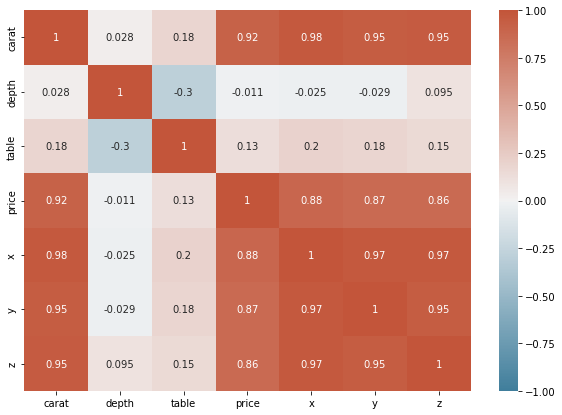

In [17]:
corrplot(df)

## Pré-processamento dos dados

### 3. Após o escalonamento das variáveis numéricas, qual é o valor máximo da variável **table**?

Mudar numericamente os valores de forma coordenada.
Como a variável price é o target, ela será desconsiderada.

In [18]:
num = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
cat = ['cut', 'color', 'clarity']

In [19]:
desc_null(df[num])

,count,mean,std,min,25%,50%,75%,max,nullCount,null%
carat,53940.0,0.797940,0.474011,0.2,0.40,0.70,1.04,5.01,0.0,0.0
depth,53940.0,61.749405,1.432621,43.0,61.00,61.80,62.50,79.00,0.0,0.0
table,53940.0,57.457184,2.234491,43.0,56.00,57.00,59.00,95.00,0.0,0.0
price,53940.0,3932.799722,3989.439738,326.0,950.00,2401.00,5324.25,18823.00,0.0,0.0
x,53940.0,5.731157,1.121761,0.0,4.71,5.70,6.54,10.74,0.0,0.0
y,53940.0,5.734526,1.142135,0.0,4.72,5.71,6.54,58.90,0.0,0.0
z,53940.0,3.538734,0.705699,0.0,2.91,3.53,4.04,31.80,0.0,0.0


In [20]:
dfNum = df[num].drop(columns='price')
dfNum.head()

,carat,depth,table,x,y,z
0,0.23,61.5,55.0,3.95,3.98,2.43
1,0.21,59.8,61.0,3.89,3.84,2.31
2,0.23,56.9,65.0,4.05,4.07,2.31
3,0.29,62.4,58.0,4.20,4.23,2.63
4,0.31,63.3,58.0,4.34,4.35,2.75


In [21]:
dfNum = feat_scale(dfNum)

dfNum.head()

,carat,depth,table,x,y,z
0,-1.198157,-0.174090,-1.099662,-1.587823,-1.536181,-1.571115
1,-1.240350,-1.360726,1.585514,-1.641310,-1.658759,-1.741159
2,-1.198157,-3.384987,3.375631,-1.498677,-1.457382,-1.741159
3,-1.071577,0.454129,0.242926,-1.364959,-1.317293,-1.287708
4,-1.029384,1.082348,0.242926,-1.240155,-1.212227,-1.117663


In [22]:
desc_null(dfNum, percentiles=True)

,count,mean,std,min,5%,25%,50%,75%,90%,99%,max,nullCount,null%
carat,53940.0,3.774170e-14,1.0,-1.261446,-1.050481,-0.839515,-0.206619,0.510664,1.502201,2.915670,8.885992,0.0,0.0
depth,53940.0,5.528923e-13,1.0,-13.087481,-1.709736,-0.523100,0.035316,0.523931,1.082348,2.687797,12.041280,0.0,0.0
table,53940.0,-3.621533e-14,1.0,-6.470013,-1.547191,-0.652132,-0.204603,0.690455,1.137985,2.928102,16.801510,0.0,0.0
x,53940.0,1.177763e-13,1.0,-5.109073,-1.284728,-0.910316,-0.027775,0.721048,1.407468,2.343497,4.465161,0.0,0.0
y,53940.0,8.638663e-14,1.0,-5.020884,-1.256004,-0.888272,-0.021474,0.705236,1.370656,2.281232,46.549216,0.0,0.0
z,53940.0,-2.522116e-13,1.0,-5.014510,-1.259367,-0.890938,-0.012376,0.710312,1.390489,2.283221,40.047205,0.0,0.0


### Após a dummyficação das variáveis categóricas, quantas colunas existem em um dataset com somente variáveis desse tipo?

In [23]:
desc_null(df[cat])

,count,unique,top,freq,nullCount,null%
cut,53940,5,Ideal,21551,0,0.0
color,53940,7,G,11292,0,0.0
clarity,53940,8,SI1,13065,0,0.0


In [24]:
dfCat = pd.get_dummies(df[cat], 
                       columns=cat, 
                       drop_first=True)

dfCat.head(3)

,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [25]:
print(f'Existem {dfCat.shape[1]} colunas')

Existem 17 colunas


### A distribuição da resposta **price** é normal e não precisa ser transformada. Essa é uma afirmação verdadeira ou falsa?

Se a resposta não for normal, a capacidade da regressão de extrair as variabilidades é reduzida.

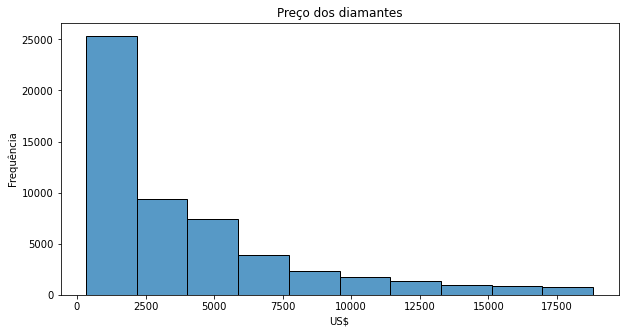

In [26]:
histplot(data=df,
         x='price',
         title='Preço dos diamantes',
         xlabel='US$', ylabel='Frequência')

A variável **price** não é normal, portanto deve ser transformada para aplicação no modelo. Essa afirmação é ***falsa***.

#### Testes de normalidade
Distância da distribuição real para distribuição padrão

In [27]:
norm_test(df['price'], type='all')

c:\Users\bruna\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Stat,P-Value
Kolmorogov,1.00000,0.0
Shapiro,0.79811,0.0
DAgostino,15096.64976,0.0


#### Log de **price**

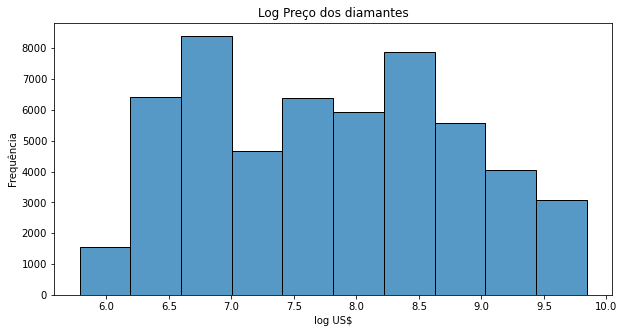

In [28]:
histplot(x=np.log(df['price']),
         title='Log Preço dos diamantes',
         xlabel='log US$', ylabel='Frequência')

## Ajuste do modelo

### 4. Ao separar o dataset em dois pedaços, o de treinamento e o de teste, quantas linhas possuirá o dataset de teste? 

(Utilize uma proporção de 20% e argumento random_state = 123456)

Dica: concatene os datasets e faça a matriz do modelo antes de fazer a separação entre treinamento e teste.

In [29]:
df_final = pd.concat([dfNum, dfCat, df['price']], axis=1)

df_final.head()

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2,price
0,-1.198157,-0.174090,-1.099662,-1.587823,-1.536181,-1.571115,0,1,0,0,...,0,0,0,0,1,0,0,0,0,326
1,-1.240350,-1.360726,1.585514,-1.641310,-1.658759,-1.741159,0,0,1,0,...,0,0,0,1,0,0,0,0,0,326
2,-1.198157,-3.384987,3.375631,-1.498677,-1.457382,-1.741159,1,0,0,0,...,0,0,0,0,0,1,0,0,0,327
3,-1.071577,0.454129,0.242926,-1.364959,-1.317293,-1.287708,0,0,1,0,...,1,0,0,0,0,0,1,0,0,334
4,-1.029384,1.082348,0.242926,-1.240155,-1.212227,-1.117663,1,0,0,0,...,0,1,0,0,1,0,0,0,0,335


#### Matriz

Antes de fechar o modelo, necessário criar a coluna **intersect** para depois poder dividir o dataset, renomear as colunas caso existam espaços

In [30]:
df_final.rename(columns={'cut_Very Good': 'cut_VeryGood'},
                inplace=True)

In [31]:
y, x = pt.dmatrices(ols_formula(df_final, 'price'),
                    data= df_final,
                    return_type='dataframe')

#### Dividir o modelo

In [32]:
x_Train, x_Test, y_Train, y_Test = train_test_split(x, y, test_size=0.2, random_state=123456)

In [33]:
data = (x_Train, x_Test, y_Train, y_Test)

for d in data:
    d.reset_index(drop=True, inplace=True)

In [34]:
print(f'O dataset de teste possui {x_Test.shape[0]} linhas')

O dataset de teste possui 10788 linhas


### 5. Utilizando o método dos mínimos quadrados e ajustando o modelo com o logaritmo natural da resposta **price** e os dados de ajuste, qual é a variável que tem o maior valor absoluto para a estatística ‘t’. 

(OBS: desconsidere o **intercept**).

In [35]:
regfit = fit_model(y = np.log(y_Train), 
                   x = x_Train)

In [36]:
print(regfit.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                 5.655e+04
Date:                Tue, 10 May 2022   Prob (F-statistic):               0.00
Time:                        15:40:41   Log-Likelihood:                 12290.
No. Observations:               43152   AIC:                        -2.453e+04
Df Residuals:                   43128   BIC:                        -2.432e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        7.1184      0.009    782.126   

A variável **x** com **t** de 205.705

### 6. Para o modelo ajustado, qual é a variável que possui o maior VIF?

In [37]:
(vif_view(x_Train, intercept=True)).sort_values(by=['VIF'], ascending=False).head(13)

,Variáveis,VIF
3,x,50.908609
0,carat,21.714137
5,z,20.059420
4,y,16.921473
17,clarity_SI1,14.808963
20,clarity_VS2,14.268302
18,clarity_SI2,11.436577
7,cut_Ideal,11.397405
19,clarity_VS1,10.829476
8,cut_Premium,8.408910


### 7. Após remover todas as variáveis para manter os VIF´s em no máximo 5, quantas variáveis sobraram no modelo? 
OBS: desconsidere o **intercept**. 
(Dica, comece removendo, uma por uma, as variáveis com maior VIF)

In [38]:
(vif_view(x_Train.drop(columns=['x'], axis=1), 
          intercept=True)).sort_values(by=['VIF'], ascending=False).head(12)

,Variáveis,VIF
16,clarity_SI1,14.804030
4,z,14.297140
19,clarity_VS2,14.267756
0,carat,13.571694
3,y,13.306365
17,clarity_SI2,11.434155
6,cut_Ideal,11.390391
18,clarity_VS1,10.829455
7,cut_Premium,8.408008
8,cut_VeryGood,7.685694


In [39]:
(vif_view(x_Train.drop(columns=['x', 'clarity_SI1'], axis=1), 
          intercept=True)).sort_values(by=['VIF'], ascending=False).head(6)

,Variáveis,VIF
4,z,14.290270
0,carat,13.502067
3,y,13.300074
6,cut_Ideal,11.188815
7,cut_Premium,8.253671
8,cut_VeryGood,7.522494


In [40]:
(vif_view(x_Train.drop(columns=['x', 'clarity_SI1', 'z'], axis=1), 
          intercept=True)).sort_values(by=['VIF'], ascending=False).head()

,Variáveis,VIF
5,cut_Ideal,11.185902
0,carat,10.158235
3,y,9.937892
6,cut_Premium,8.251359
7,cut_VeryGood,7.520979


In [41]:
(vif_view(x_Train.drop(columns=['x', 'clarity_SI1', 'z', 'cut_Ideal'], axis=1), 
          intercept=True)).sort_values(by=['VIF'], ascending=False).head(2)

,Variáveis,VIF
0,carat,10.152771
3,y,9.937048


In [42]:
vif_view(x_Train.drop(columns=['x', 'clarity_SI1', 'z', 'cut_Ideal', 'carat'], axis=1), 
          intercept=True)

,Variáveis,VIF
0,depth,1.172445
1,table,1.535214
2,y,1.282658
3,cut_Good,1.310436
4,cut_Premium,1.553306
5,cut_VeryGood,1.348768
6,color_E,2.002190
7,color_F,2.004205
8,color_G,2.188579
9,color_H,1.944377


Sobraram 18 variáveis.

## Qualidade do ajuste
### 8. Qual é o R² para os dados de teste com o modelo sem as variáveis removidas?

Fazer um novo ajuste retirando as variáveis de alto VIF

In [43]:
regfit2 = fit_model(y = np.log(y_Train),
                    x = x_Train.drop(columns=['x', 'clarity_SI1', 'z', 'cut_Ideal', 'carat'], axis=1))

print(regfit2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                 2.069e+04
Date:                Tue, 10 May 2022   Prob (F-statistic):               0.00
Time:                        15:40:45   Log-Likelihood:                -13037.
No. Observations:               43152   AIC:                         2.611e+04
Df Residuals:                   43133   BIC:                         2.628e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        7.8353      0.006   1408.633   

In [44]:
pred_y = predict_table(y = np.log(y_Test), 
                       fit = regfit2.predict(x_Test.drop(columns=['x', 'clarity_SI1', 'z', 'cut_Ideal', 'carat'], axis=1)),
                       columns=['priceReal', 'pricePrevisto'],
                       residual=True
                       )
pred_y.head()

,priceReal,pricePrevisto,Res
0,7.989560,7.920652,0.068908
1,9.259035,9.380046,-0.121011
2,7.064759,7.205302,-0.140543
3,9.287024,8.737650,0.549374
4,7.111512,7.270200,-0.158688


In [45]:
adj_quality(pred_y)

,R²,RMSE
0,0.960254,0.201273


## Análise de resíduos
### 9. Utilizando os dados de teste, faça a análise de resíduos e responda: eles estão de acordo com a hipótese para a regressão linear?

In [46]:
norm_test(pred_y['Res'])

c:\Users\bruna\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Stat,P-Value
Kolmorogov,0.34137,0.0


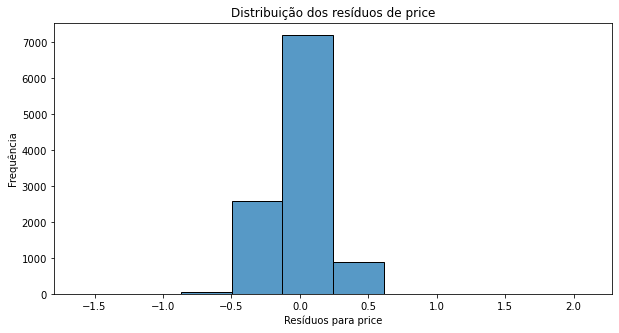

In [47]:
histplot(data=pred_y,
         x='Res', xlabel='Resíduos para price',
         ylabel='Frequência',
         title='Distribuição dos resíduos de price')

Text(0, 0.5, 'Resíduo')

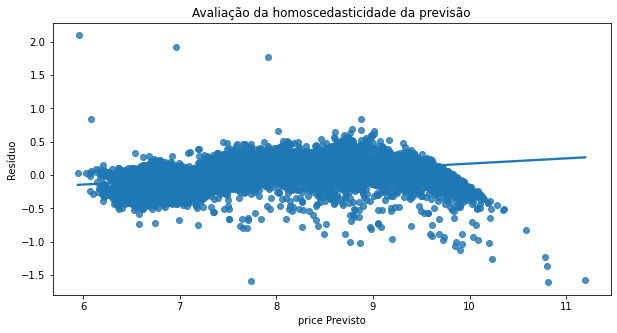

In [48]:
plt.figure(figsize=(10, 5))

sns.regplot(data=pred_y,
            x='pricePrevisto',
            y='Res')

plt.title('Avaliação da homoscedasticidade da previsão')
plt.xlabel('price Previsto')
plt.ylabel('Resíduo')

A distribuição não é normalizada e heteroscedástica, novos ajustes devem ser feitos para melhorar o modelo.

## Regressão Regularizada
### 10. Utilizando a regressão regularizada tipo **Ridge** e o dataset com TODOS os regressores, qual dentre os seguintes valores de **alpha** deixa o modelo com o maior R² para os dados de teste?

In [49]:
regRidge2 = Ridge()

In [50]:
alpha = [10, 100, 1000, 10000]
adj = pd.DataFrame({'alpha': np.nan,
                    'R²': np.nan},
                    index=[0])

for a in alpha:
    regRidge2 = fit_model(x=x_Train, y=np.log(y_Train),
                          type='Ridge', alpha=a)

    predRidge = predict_table(y=y_Test,
                              fit=pd.DataFrame(np.exp(regRidge2.predict(x_Test))),
                              columns= ['priceReal', 'pricePrevisto'],
                              residual=True)
    r2 = metrics.r2_score(predRidge.loc[:,predRidge.columns[0]], 
                          predRidge.loc[:, predRidge.columns[1]])
    adj = adj.append({'alpha': a,
                      'R²': r2},
                      ignore_index=True)

adj.dropna()

,alpha,R²
1,10.0,0.923530
2,100.0,0.898674
3,1000.0,0.745201
4,10000.0,0.635746
